# BEAST Workflow Example

In this notebook we will be walking through a standard BEAST workflow example using some data from M31.

You'll need a couple of datafiles to get started though. Please visit https://www.dropbox.com/sh/91aefrp9gzdc9z0/AAC9Gc4KIRIB520g6a0uLLama?dl=0 and download all the files (can omit wrangling_data.ipynb) into the same folder this Jupyter Notebook is in. 

Before we do anything, we have to import the following packages. This seems like a lot but they are all here to make our lives easier down the line. And running them all as the first cell means that if our kernel ever crashes halfway through, we can just reimport everything at once rather than stepping through the cells individually.

In [1]:
import h5py

import numpy as np
from astropy import wcs
from astropy.io import fits
from astropy.table import Table
#import tables

import glob
import os
import types
import argparse

import matplotlib.pyplot as plt

from beast.plotting import (plot_mag_hist, plot_ast_histogram, plot_noisemodel)

from beast.tools.run import (
    create_physicsmodel,
    make_ast_inputs,
    create_obsmodel,
    run_fitting,
    merge_files,
    create_filenames,
)

from beast.physicsmodel.grid import FileSEDGrid
from beast.fitting import trim_grid
import beast.observationmodel.noisemodel.generic_noisemodel as noisemodel


from beast.tools.run import (
    run_fitting,
    merge_files,
)    
    
from beast.tools import (
     create_background_density_map,
     split_ast_input_file,
     split_catalog_using_map,
#     subdivide_obscat_by_source_density,
     cut_catalogs,
#     split_asts_by_source_density,
     setup_batch_beast_trim,
#     setup_batch_beast_fit,
 )

import importlib

Auto-detected type: fits
Auto-detected type: fits


# Step -1. Obtain data file and convert to fits file

Sometimes photometric catalogs are delivered as HDF5 files. While these are great for storing data in heirarchies, it's a little hard to work with directly, so we have to convert our HDF5 file to a FITS file.

Thankfully, our photometric catalog for this example is already in a FITS format so we don't need to worry about this and can move straight on to Step 1.

# Step 1a. Make magnitude histograms

The first thing we need to do is understand the range of stellar magnitudes we are working with in this data set.

To do this we can make histograms of all the magnitudes of all the stars in all the different filters from the photometric catalog. This is done so that we know where the peaks of the histograms are in each filter. These peaks will then be used later when we make source density maps. 

Essentially what happens is that, for the density maps, we only count objects within a certain range, currently set to mag_cut = 15 - (peak_for_filter-0.5). So if the peak was 17.5, then the objects that would be counted would have to be in the range between 15 and 18. 

The reason we only count brighter sources is because dimmer sources tend to not be properly observed, especially as the magnitudes near the telescope limit. There will always be far more dim sources than bright sources, but if we know how many bright sources there are, then we can extrapolate as to how many dim sources there should be, and probably get a better understand from that than if we were to try and actually count all the dim sources we detect.  

**Variable Information**

* **field_name** : the string name of the main photometric catalog we are working with. This variable will be used to rename a lot of different files in the future which is why we have it as a separate variable.
* **gst_file** : stands for good-stars, this is the full name for the original photometric catalog we are working with.

In [2]:
field_name = "M31-B09-EAST_chunk"
gst_file = "./%s.st.fits" %field_name

We can see what type of data this fits file holds by making a table. There should be around 50,000 sources in this calalog, which is quite small compared to the original file.

*Note: **st** stands for stars. We also sometimes name things **gst** for good stars to signify when cuts have been made.*

In [3]:
hdul = fits.open(gst_file)
Table(hdul[1].data)

F814W_ST,F814W_GST,F475W_ST,F475W_GST,F275W_ST,F275W_GST,F160W_ST,F160W_GST,F336W_ST,F336W_GST,F110W_ST,F110W_GST,X,Y,RA,DEC,CHI_GL,SNR_GL,SHARP_GL,ROUND_GL,CROWD_GL,F475W_COUNT,F475W_SKY,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_TRANS,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F814W_COUNT,F814W_SKY,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_TRANS,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F275W_COUNT,F275W_SKY,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_TRANS,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F336W_COUNT,F336W_SKY,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_TRANS,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F110W_COUNT,F110W_SKY,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_TRANS,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F160W_COUNT,F160W_SKY,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_TRANS,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,EXT,CHIP,MAJAX_GL,OBJTYPE_GL,F475W_FLAG,F814W_FLAG,F275W_FLAG,F336W_FLAG,F110W_FLAG,F160W_FLAG
bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
True,True,True,True,True,True,True,True,True,True,True,True,869.8900000046692,44.40999999483233,11.131832570656686,41.603419438518735,4.03,2917.0,-0.03,0.02,0.251,233000000.0,87358.19,9.039999999999999e-08,1.3800000000000002e-09,17.61,17.721,0.017,2.48,65.4,0.005,0.038,0.175,198000000.0,102360.6,1.59e-07,1.27e-09,16.996,16.986,0.009000000000000001,1.77,124.8,0.01,0.049,0.22699999999999998,5970000.0,2256.98,1.25e-07,1.16e-09,17.255,nan,0.01,2.92,107.7,-0.038,0.018000000000000002,0.086,23800000.0,7534.45,1.69e-07,6.92e-10,16.932000000000002,nan,0.004,2.63,243.9,-0.031,0.059000000000000004,0.084,79700000.0,88039.23,1.6e-07,2.58e-10,16.992,nan,0.002,2.23,619.1,-0.004,0.1,0.35,56000000.0,93657.59,1.8e-07,2.53e-10,16.864,nan,0.002,1.51,708.8,-0.018000000000000002,0.027000000000000003,0.396,0,1,165,1,2,2,0,0,0,0
True,True,True,True,True,True,True,True,True,True,True,True,868.3900000040028,42.189999993549804,11.13180414033402,41.60338891056161,4.13,2566.5,-0.05,0.028999999999999998,0.27699999999999997,125000000.0,46004.84,4.85e-08,2.51e-10,18.285999999999998,18.412,0.006,3.02,193.3,-0.053,-0.006,0.231,118000000.0,77080.48,9.23e-08,1.24e-09,17.587,17.577,0.015,5.87,74.3,-0.096,0.044000000000000004,0.324,4360000.0,2332.74,9.15e-08,7.099999999999999e-10,17.597,nan,0.008,2.08,128.8,-0.057,0.008,0.092,16500000.0,8339.99,1.1699999999999999e-07,9.25e-10,17.329,nan,0.009000000000000001,3.74,126.5,-0.085,-0.006999999999999999,0.106,49500000.0,82165.18,9.92e-08,2.82e-10,17.508,nan,0.003,2.79,352.5,0.013000000000000001,-0.079,0.516,35100000.0,87515.55,1.13e-07,3.31e-10,17.371,nan,0.003,2.18,340.0,-0.026000000000000002,-0.004,0.635,0,1,75,1,2,2,0,2,0,0
True,True,False,False,False,False,True,True,False,False,True,True,297.1500000049341,22.169999994536283,11.135275566985227,41.595888643103535,1.17,1663.1,-0.08800000000000001,0.061,0.008,29910.7,10270.95,1.1499999999999999e-11,1.34e-12,27.348000000000003,27.805999999999997,0.126,1.34,8.6,-0.634,0.177,0.025,4160000.0,21190.25,3.17e-09,1.0000000000000001e-11,21.248,21.423000000000002,0.003,0.9,316.3,-0.063,0.049,0.001,-1.7,44.5,-6.900000000000001e-14,1.49e-11,nan,nan,9.999,0.87,-0.0,1.058,2.951,0.0

As we can see, there's a lot of columns and even more rows. For plotting the magnitude histograms, we're going to be interested in any column that contains the name VEGA. These are the columns with the magnitudes for each filter.

We could also use the X and Y columns to plot where are the sources are located, or the RA and DEC to map their actual position in the sky.

In larger projects we might have multiple fields to analyze during each run, so there would be multiple **field_names**. Since this is just a small example, we just have one field so our index will always be equal to **0**.

In [4]:
# the list of fields (we only have 1 for this example.)
field_names = [field_name]

Now we can create some histogram plots to visualize the magnitude distribution of our sources.

In [5]:
# this 'if' statement just checks if there's already a histogram file
if not os.path.isfile('./'+field_names[0]+'.st_maghist.pdf'):
    peak_mags = plot_mag_hist.plot_mag_hist(gst_file, stars_per_bin=70, max_bins=75)

You can check out the results for the histograms in the file ending with **_maghist.pdf**

From this plot, we can also see what filters exist for the data. 

# Step 1b. Make source density maps

Next we'll be creating source density maps. These are maps of our data field colored such that they show how many stars/sources there are in each degree field. The standard size is 5 arc seconds squared. The size can easily be changed by modifying the **pixsize** variable below.

In [6]:
# Pick the filter with the dimmest peak from the histogram
ref_filter =["F475W"]

# choose a filter to use for removing artifacts
# (remove catalog sources with filter_FLAG > 99)
flag_filter = ["F275W"]

In [7]:
# check to see if the sourde density file already exists
if not os.path.isfile(gst_file.replace(".fits", "_source_den_image.fits")):
    # if not, run all this other code
    
    # - pixel size of 5 arcsec
    # - use ref_filter[b] between vega mags of 15 and peak_mags[ref_filter[b]]-0.5
        # since we're only working with one field, our index b is set to 0
    sourceden_args = types.SimpleNamespace(
        subcommand="sourceden",
        catfile=gst_file,
        pixsize=5,
        npix=None,
        mag_name=ref_filter[0]+ "_VEGA",
        mag_cut=[17, peak_mags[ref_filter[0]] - 0.5],
        flag_name=flag_filter[0]+'_FLAG',
    )
    create_background_density_map.main_make_map(sourceden_args)

In [8]:
# new file name with the source density column
gst_file_sd = gst_file.replace(".fits", "_with_sourceden.fits")

This function should create 3 files: 
* *M31-B09-EAST_subset.st_source_den_image.fits* : a file for viewing the source density information in ds9 or with matplotlib

* *M31-B09-EAST_subset.st_sourceden_map.hd5* : the same file as source_den_image but now with even more data (the split_catalog_using_map function will end up using this file later on) 

* *M31-B09-EAST_subset.st_with_sourceden.fits* : the same as the original photometric file (gst_file) but now with an additional column for what density bin the source is located in

### View the fits images of the source density maps

Now that we have the source density maps outputted, we can plot the image and see that the density looks like.

In [9]:
# open the fits file
hdu_list = fits.open("./%s.st_source_den_image.fits"%field_name)
hdu_list.info()

# extract the image data
image_data = hdu_list[0].data

# take a look at what the image should look like
print(type(image_data))
print(image_data.shape)

# close the fits file
hdu_list.close()

Filename: ./M31-B09-EAST_chunk.st_source_den_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   (12, 12)   float64   
<class 'numpy.ndarray'>
(12, 12)


Text(0.5, 1.0, 'Density of Sources per 5 arcsec^2')

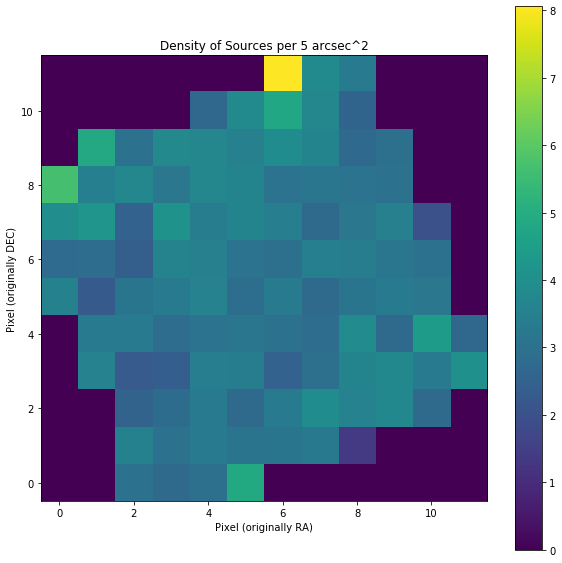

In [10]:
# plot the extracted image data
fig = plt.figure(0, [10,10])
im = plt.imshow(image_data, origin="lower")
plt.colorbar(im)
plt.xlabel("Pixel (originally RA)")
plt.ylabel("Pixel (originally DEC)")
plt.title("Density of Sources per 5 arcsec^2")

# Step 1c. Set up datamodel file

At this point, we have a basic understanding of the information we are working with, so it's about time we set up our datamodel file. 

The datamodel file is a sort of catch-all file used to store any sort of infomation we might need to run the BEAST code on our data. We'll go through and talk about what all the different variables mean, and which ones would need to be changed for any future projects.

Go ahead and open the datamodel.py file in a text editor now and ensure that the following variables match:

*  **project** : the same as the field_name variable we noted earlier
    * *project = "M31-B09-EAST_chunk" *
* **surveyname** : the overall name for the survey (this variable isn't actually important for the code)
    * *surveyname = "PHAT-M31"*
* **filters** : the full filter names from the photometric catalog, also the names that show up in our magnitude histograms so you can add them from there
    * *filters = ["HST_WFC3_F475W", "HST_WFC3_F275W", "HST_WFC3_F336W", "HST_WFC3_F814W", "HST_WFC3_F110W", "HST_WFC3_F160W",]*
    
* **base filters** : shortened versions of the filter names
    * *basefilters = ["F475W", "F275W", "F336W", "F814W", "F110W", "F160W"]*
* **obsfile** : the name of the photometric catalog (now including the source density information
    * *obsfile = "./M31-B09-EAST_chunk.st_with_sourceden_cut.fits"*
    
* **ast_with_positions** : make sure is set to *True* if you have the locations included in your obsfile

* **ast_density_table** : the source density map created in step 1b  
    * *ast_density_table = './M31-B09-EAST_chunk.st_sourceden_map.hd5'*
    
* **ast_reference_image** : the original photometric FITS catalog which is required if you use the ast_with_positions as true  
    * *ast_reference_image = "./M31-B09-EAST_chunk_F475W_drz.chip1.fits"*
    
* **astfile** : the file of ASTs we will be creating in step 3, but since ASTs normally have to be processed by a specialist, we have already included a finished AST file for us to use in this example
    * *astfile = "M31-B09_EAST_chunk.gst.fake.fits"*
    
* **n_subgrid** : the number of subgrids to use for generating the physics model later on (with 1 meaning no subgrids)
    * *n_subgrid = 1*

This file is also where you specify the parameters and resolution of your physics model which will become relevant in step 2. The resolution of these parameters for your own runs will differ depending on what sorts of ASTs you want to model. There are 8 parameters that can be set.

1. **Distance** : either a fixed value or a range with stepsizes
2. **Velocity** : what is the heliocentric velocity of your location or galaxy in km/s
3. **Age** : the log10 age range of the ASTs being modeled
4. **Mass** : the mass of the ASTs
5. **Metallicity** : the metallicity range of the ASTs

6. **A(v)** : the range of dust extinction in magnitudes that could be dimming the intrinsic brightness of the ASTs
7. **R(v)** : the range of dust grain sizes 
8. **f(A)** the mixture factor between the Milky Way and Small Magellanic Cloud extinction curves


In [11]:
import datamodel

importlib.reload(datamodel)

Auto-detected type: fits
Auto-detected type: fits


<module 'datamodel' from '/home/christina/beast_testing/BEAST_example/datamodel.py'>

Our goal after this would normally be to eventually run a bunch of **ASTs** (Artificial Star Tests), but before we can do that, we need to generate the fake stars to use.

Since the ASTs would normally need to be analyzed by a specialist after being created and that's a little overkill for a small example, these next couple of steps are just to illustrate how the ASTs are actually generated. A finished file of the analyzed ASTs already exists so we will end up using that in step 4 and beyond.



# Step 2. Create physics model

In order to generate a diverse and representative sample of fake stars to use for our ASTs, we need to set up a N-dimensional model of possible stellar parameters, so that we can easily and randomly select stars from the model.

This model is called a **physics model**, and we will be using the parameters set in the datamodel.py file to create this N-dimensional grid.

*As a quick note, the resolution on the stellar parameters (the step size, often specified as the third input e.g. logt = [6.0, 10.13, 1.0], where 1.0 is the step size) is the main factor driving how long this physics grid will take to set up. If things take a very long time to run, consider making the step size larger for testing's sake.*

Sometimes we are able to have access to high-performance computing resources, meaning we can split the physics model into subgrids and run them in parallel, cutting a lot of the computation time. While we're like not running this notebook in parallel here, we've still specified a number of subgrids in the datamodel.py file. 

We can check how many subgrids are set up.

In [12]:
datamodel.n_subgrid

1

So we can now see that we've asked for 1 grid in the datamodel.py file.

If we've already generated a physics model, we certainly don't want to run it again, so the following code checks to make sure all the subgrids for the physics model are present.

In [13]:
# set up the naming conventions for the physics model
gs_str = ""

# this is only relevant if we run with multiple subgrids
if datamodel.n_subgrid > 1:
    gs_str = "sub*"

# collects any physics models that have already been created
# if none have, sed_files will be empty
sed_files = glob.glob(
    "./{0}/{0}_seds.grid{1}.hd5".format(field_names[0], gs_str)
)

In [14]:
# only make the physics model they don't already exist
if len(sed_files) < datamodel.n_subgrid:
    # directly create physics model grids
    create_physicsmodel.create_physicsmodel(nprocs=1, nsubs=datamodel.n_subgrid)

In [15]:
# list of SED files (physics models)
model_grid_files = sorted(
    glob.glob(
        "./{0}/{0}_seds.grid{1}.hd5".format(field_names[0], gs_str)
    )
)
sed_files = model_grid_files

Hopefully a spectral grid and an SED grid should have started generating. In the end you should have a new folder with the same name as your project, with a one SED and spectral grid if you have only 1 subgrid.

# Step 3. Create Input ASTs!

Now that we have our physics model generated, we can start to generate some input ASTs. ASTs are artificial sources inserted into the observations we have, which are then extracted with the same software that was used for the original photometry catalog. So the step that we're running now is just generating the artifical sources that will then later be inserted. 

We need to make sure that the ASTs cover the same range of magnitudes as our original photometric catalog does, so to do that


First thing's first, we're gonna check that there isn't already a file of AST inputs present in the folder we're working in.

In [16]:
# only create an AST input list if the ASTs don't already exist
ast_input_file = ("./{0}/{0}_inputAST.txt".format(field_names[0]))

ast_input_file

'./M31-B09-EAST_chunk/M31-B09-EAST_chunk_inputAST.txt'

Now we can create the ASTs if they don't already exist.

The way that 

In [29]:
if not os.path.isfile(ast_input_file):
    make_ast_inputs.make_ast_inputs(flux_bin_method=True)

In [18]:
ast = Table.read(ast_input_file, format="ascii")
ast

zeros,ones,X,Y,HST_WFC3_F475W,HST_WFC3_F275W,HST_WFC3_F336W,HST_WFC3_F814W,HST_WFC3_F110W,HST_WFC3_F160W
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
0,1,408.03456,897.52366,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,419.17151,897.33494,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,427.91019,897.03469,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,414.32003,893.16622,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,425.36739,897.72325,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,419.51676,899.53858,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,423.49592,895.02481,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,419.74966,899.3343,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148
0,1,416.9429,896.49331,33.95055,38.18357,36.99705,28.99129,27.22613,26.11148


In [30]:
33418/6

5569.666666666667

### Check to see how the SEDs and the ASTs compare

The histogram that is produced should have both the SED distribution and the AST distribution plotted on it. The thing we want to test for is whether the AST distribution fully samples the SED range.

In [19]:
plot_ast_histogram.plot_ast(ast_file = ast_input_file, sed_grid_file = model_grid_files[0])

Auto-detected type: hd5


/home/christina/anaconda3/envs/astroconda/lib/python3.6/site-packages/beast/plotting/plot_ast_histogram.py:73: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  label='ASTs'
/home/christina/anaconda3/envs/astroconda/lib/python3.6/site-packages/beast/plotting/plot_ast_histogram.py:84: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  label='Model grid'
/home/christina/anaconda3/envs/astroconda/lib/python3.6/site-packages/beast/plotting/plot_ast_histogram.py:73: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  label='ASTs'
/home/christina/anaconda3/envs/astroconda/lib/python3.6/site-packages/beast/plotting/plot_ast_histogram.py:84: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed 

# Step 4. Edit/Split the Catalog

We have to remove sources from the input photometry catalog that are in regions without full imaging coverage or flagged as bad in flag_filter. This step should mostly just be removing any sources where one of the filters might not have a value.

In [56]:
gst_file_cut = gst_file.replace(".fits", "_with_sourceden_cut.fits")

# check to see if the trimmed catalog already exists
if not os.path.isfile(gst_file_cut):
    # and if not
    cut_catalogs.cut_catalogs(
        gst_file_sd,
        gst_file_cut,
        partial_overlap=True,
        flagged=True,
        flag_filter=flag_filter[0],
        region_file=True,
    )

# Step 4.5 Update Datamodel
**After making these cuts, we should now update the obs_file name in datamodel.py (~line 62)  with this new trimmed filename: './M31-B09-EAST_chunk.st_with_sourceden_cut.fits'**

In [21]:
importlib.reload(datamodel)

Auto-detected type: fits
Auto-detected type: fits


<module 'datamodel' from '/home/christina/beast_testing/BEAST_example/datamodel.py'>

# Step 5. Edit/Split the ASTs

Now for this step, we're doing things a little unconventionally since actually placing all the input ASTs we generated in Step 3 back into our image and rerunning the analysis would take several days of computational time. 

Instead, we've already procurred a polished AST results file (kindly provided by Ben Williams from the University of Washington) which we can use to complete our analysis. The AST file should be named *'./M31-B09-EAST_chunk.gst.fake.fits'* while the input ASTs we generated were named *'./M31-B09-EAST_chunk/M31-B09-EAST_chunk_beast_inputAST.txt'*.

We will now use the same cutting procedure as for the catalog to trim down the AST file with the same criteria as in Step 4.

In [22]:
ast_file = "./" + field_names[0] + ".gst.fake.fits"
ast_file 

'./M31-B09-EAST_chunk.gst.fake.fits'

In [62]:
Table.read(ast_file)

F110W_IN,F110W_RATE,F110W_RATERR,F110W_VEGA,F110W_STD,F110W_ERR,F110W_CHI,F110W_SNR,F110W_SHARP,F110W_ROUND,F110W_CROWD,F110W_FLAG,F160W_IN,F160W_RATE,F160W_RATERR,F160W_VEGA,F160W_STD,F160W_ERR,F160W_CHI,F160W_SNR,F160W_SHARP,F160W_ROUND,F160W_CROWD,F160W_FLAG,F275W_IN,F275W_RATE,F275W_RATERR,F275W_VEGA,F275W_STD,F275W_ERR,F275W_CHI,F275W_SNR,F275W_SHARP,F275W_ROUND,F275W_CROWD,F275W_FLAG,F336W_IN,F336W_RATE,F336W_RATERR,F336W_VEGA,F336W_STD,F336W_ERR,F336W_CHI,F336W_SNR,F336W_SHARP,F336W_ROUND,F336W_CROWD,F336W_FLAG,F475W_IN,F475W_RATE,F475W_RATERR,F475W_VEGA,F475W_STD,F475W_ERR,F475W_CHI,F475W_SNR,F475W_SHARP,F475W_ROUND,F475W_CROWD,F475W_FLAG,F814W_IN,F814W_RATE,F814W_RATERR,F814W_VEGA,F814W_STD,F814W_ERR,F814W_CHI,F814W_SNR,F814W_SHARP,F814W_ROUND,F814W_CROWD,F814W_FLAG,YIN,XIN,Y,X,RA_J2000,DEC_J2000
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float64,float64,float64,float64,float64,float64
33.267,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,31.935,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,44.611,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,45.472,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,41.082,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,35.465,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,7.389484365972712,3.6699673430471402,7.389484365972712,3.6699673430471402,11.145614732485846,41.59773092319124
33.267,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,31.935,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,44.611,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,45.472,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,41.082,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,35.465,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,9.188675903235886,4.602542965133008,9.188675903235886,4.602542965133008,11.148956385132271,41.599026017115044
33.267,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,31.935,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,44.611,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,45.472,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,41.082,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,35.465,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,7.48594129972647,5.80299643256212,7.48594129972647,5.80299643256212,11.14579404466301,41.60069345799913
33.267,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,31.935,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,44.611,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,45.472,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,41.082,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,35.465,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,2.114894903876398,5.902286117142443,2.114894903876398,5.902286117142443,11.135818296825672,41.60083124801925
33.267,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,31.935,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,44.611,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99.999,99,45.472,0.0,9999.0,99.999,99.999,99.999,99.999,99.999,99.99

In [23]:
# - ASTs
ast_file_cut = ast_file.replace(".fits", "_cut.fits")

# check to see if the trimmed AST file already exists
if not os.path.isfile(ast_file_cut):
    cut_catalogs.cut_catalogs(
        ast_file,
        ast_file_cut,
        partial_overlap=True,
        flagged=True,
        flag_filter=flag_filter[0],
        region_file=True,
    )

# so now we've generated the cut ast file

We can plot the AST magnitudes against our original source magnitudes again, just to check that we are within a reasonable range.

In [24]:
# check to see if the plotted AST file already exists
if not os.path.isfile(ast_file_cut.replace(".fits", "_maghist.pdf")):
    
    test = plot_mag_hist.plot_mag_hist(ast_file_cut, stars_per_bin=200, max_bins=30)

    # and so this should plot a histogram of the different asts that remain after cutting

# Step 5.5 Update Datamodel Again

**Same with these cuts, we now have to update the astfile variable in datamodel.py (~line 144)  with this new trimmed filename: './M31-B09-EAST_chunk.gst.fake_cut.fits'**

In [71]:
importlib.reload(datamodel)

Auto-detected type: fits
Auto-detected type: fits


<module 'datamodel' from '/home/christina/beast_testing/BEAST_example/datamodel.py'>

# Step 6. Split catalog by source density

For the next fitting step, we're going to have to break our catalog and AST file into bins based on the source density, and then further into sub-bins if there are more than ~6250 sources in the bins. 

We split things into source density bins so that we can later study how the actual source density of region effects the noise or bias. We further split things into sub-bins, just to make things a little more computationally accessible.

One thing to note is that the source density bins are first sorted by magnitude (typically F475W if it's there) before being split into sub-bins. This means that the first sub-bin file (for a source density bin that has more than 6250 sources) will end up having all the dimmest sources or any sources with NAN values, and the last sub file will have all the brightest sources. This will become handy in Step 8 when we create physics (SED) models and noisemoels tailored specifically to each sub-bin file.

In [26]:
# check to see if any sub files exist yet
if len(glob.glob(gst_file_cut.replace('.fits','*sub*fits') )) == 0:
    # if no sub files exist, they can now be created
    # a smaller value for n_per_file will mean more individual files/runs,
    # but each run will take a shorter amount of time
    
    #split the gst file and ast file
    split_catalog_using_map.split_main(
        gst_file_cut,
        ast_file_cut,
        gst_file.replace('.fits','_sourceden_map.hd5'), #get full sourceden_mad.hd5 file from dust folder
        bin_width=1,
        n_per_file=6250, #this is the max number of sources per bin before it splits 

    )

So these are all the different source density bins, with some of them being split into sub bins to limit the number of entries to ~6250. 

Rather than reading in all the files we just created, the developers of this code instead wrote this handy little function that generates a dictionary of all the files that have just been created (assuming the function ran correctly) and all the files that we hope to generate in the future.

Because of this, I recommend not changing any of the naming for Step 6 or beyond, just because that then makes this dictionary point to incorrect files.

In [72]:
# generate file name lists
file_dict = create_filenames.create_filenames(
    use_sd=True, nsubs=datamodel.n_subgrid
)

Auto-detected type: fits
Auto-detected type: fits


If we take a look in our folder, we should be able to see some bins with sub-bins notation. We can do a quick check to see if the sub-binning generated from the dictionary matchs up with the files split in our data folder.

In [74]:
sd_sub_info = file_dict["sd_sub_info"]
sd_sub_info

[['2', '0'],
 ['3', '0'],
 ['3', '1'],
 ['3', '2'],
 ['4', '0'],
 ['4', '1'],
 ['4', '2'],
 ['4', '3'],
 ['4', '4'],
 ['4', '5'],
 ['5', '0'],
 ['6', '0'],
 ['9', '0']]

**Hint: If sd_sub_info is empty, make sure you've updated the obsfile and astfile variables in datamodel (Step 4.5 and 5.5), reloaded the datamodel, and try to run create_filenames again.**

In [75]:
# - number of SD bins
temp = set([i[0] for i in sd_sub_info])
print("** total SD bins: " + str(len(temp)))

# - the unique sets of SD+sub
unique_sd_sub = [
    x for i, x in enumerate(sd_sub_info) if i == sd_sub_info.index(x)
]
print("** total SD subfiles: " + str(len(unique_sd_sub)))


** total SD bins: 6
** total SD subfiles: 13


Just another quick was to ensure that all the binning and sub-binning matches up. If it doesn't, none of the next steps will run properly.

# Step 7. Make Noise Models

We're now on to creating our observational noise models! These models will be used to adjust the bias and uncertainty in Steps 8 and 9. 

The **uncertainty** (also known as sigma) is the standard deviation calculated for all the detected sources.

The **bias** is the average offset between the input flux we have for the ASTs and the measured flux. Bias tends to become more prominent in regions of high source density, where it's harder to detect all the faint stars if they get blended together. If this happens, then some of the stars are assumed to be part of the background (raising the average), which gets subtracted from the detected sources. If the background is raised, then the detected sources are measured to be systematically fainter than they should be.

In [42]:
# these are what the noise files should be named once generated
noise_files = file_dict["noise_files"]

In [43]:
# gather up the split AST files
ast_file_list = sorted(glob.glob(datamodel.astfile.replace(".fits", "*_bin*")))
ast_file_list

['M31-B09-EAST_chunk.gst.fake_cut_bin2.fits',
 'M31-B09-EAST_chunk.gst.fake_cut_bin3.fits',
 'M31-B09-EAST_chunk.gst.fake_cut_bin4.fits',
 'M31-B09-EAST_chunk.gst.fake_cut_bin5.fits',
 'M31-B09-EAST_chunk.gst.fake_cut_bin6.fits',
 'M31-B09-EAST_chunk.gst.fake_cut_bin9.fits']

In [48]:
# create the noise model with our ASTs  
create_obsmodel.create_obsmodel(
        use_sd=True, nsubs=datamodel.n_subgrid, nprocs=1
    )

Auto-detected type: fits
Auto-detected type: fits
sd list:  ['2', '3', '4', '5', '6', '9']

M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin2.grid.hd5 already exists
M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin2.grid.hd5

creating M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin3.grid.hd5
Auto-detected type: hd5
Auto-detected type: fits


Evaluating model: 100%|██████████| 6/6 [00:00<00:00, 30.40it/s]


Writing to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin3.grid.hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin3.grid.hd5

creating M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
Auto-detected type: hd5
Auto-detected type: fits


Evaluating model: 100%|██████████| 6/6 [00:00<00:00, 29.23it/s]


Writing to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5

creating M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin5.grid.hd5
Auto-detected type: hd5


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s]

Auto-detected type: fits


Evaluating model: 100%|██████████| 6/6 [00:00<00:00, 31.95it/s]


Writing to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin5.grid.hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin5.grid.hd5

creating M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin6.grid.hd5
Auto-detected type: hd5


Evaluating model:  67%|██████▋   | 4/6 [00:00<00:00, 39.19it/s]

Auto-detected type: fits


Evaluating model: 100%|██████████| 6/6 [00:00<00:00, 39.15it/s]


Writing to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin6.grid.hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin6.grid.hd5

creating M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin9.grid.hd5
Auto-detected type: hd5


Evaluating model:   0%|          | 0/6 [00:00<?, ?it/s]

Auto-detected type: fits


Evaluating model: 100%|██████████| 6/6 [00:00<00:00, 33.88it/s]


Writing to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin9.grid.hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin9.grid.hd5


# Step 7.5 Visualize Noise Models (Optional)

This next cell is some older plotting code for visualizing the noise models. It should (hopefully) work if you uncomment and run it, but the lack of a log scale for the y-axis makes the results a little harder to fully interpret.

As an alternative, the same plot is recreated down below but the steps have been broken down to hopefully help you gain a better sense of what's going on (and plot the y-axis with a log scale). 

If you're not interested in visualizing the noise models, feel free to skip this step.

In [49]:
# plot_noisemodel.plot_noisemodel(sed_file="M31-B09-EAST_chunk/M31-B09-EAST_chunk_seds.grid.hd5", 
#                                 noise_file_list=noise_files, 
#                                 plot_file="noise_model_plot.png")

### Alternative plot
I'm going to try to recreate this noise model plot using some of the filters used in Dreiss' paper.


In [20]:
# set some basic plotting stuff
samp=100 # makes it so we plot every 100th point from the SED files
color=["black", "red", "gold", "lime", "xkcd:azure"]
label=None

# load in the physics model as an object
sed_object = FileSEDGrid(sed_files[0])

# read the flux values for all the sources
if hasattr(sed_object.seds, "read"):
    sed_grid = sed_object.seds.read()
else:
    sed_grid = sed_object.seds
    
sed_object.seds.shape

Auto-detected type: hd5


(510048, 6)

So this sed_grid comes from back in Step 2, where the physics model created ~500,000 points based off of the original parameters we specified in the datamodel, and for each point, the expected flux for each filter is calculated. We can now use the noise models we created with the ASTs to see how the bias and uncertainty is expected to scale with the flux from a specific filter. We'll plot the log10 of the flux on the x-axis and then the flux-normalized uncertainty and bias on the y-axis. We can also color our results based on what source density bin the ASTs came from, as well as compare how different filters compare to one another


In [52]:
# pull out the list of filters
filter_list = sed_object.filters

# for this plot, I just want to plot the first two filter
# feel free to change this and see what the other filters look like
filter_list_plot = filter_list[0:2]
n_filter = len(filter_list_plot)

* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin2.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin3.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin3.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin3.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin4.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin5.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin6.grid.hd5
* reading M31-B09-EAST_chunk/M31-B09-EAST_chunk_noisemodel_bin9.grid.hd5


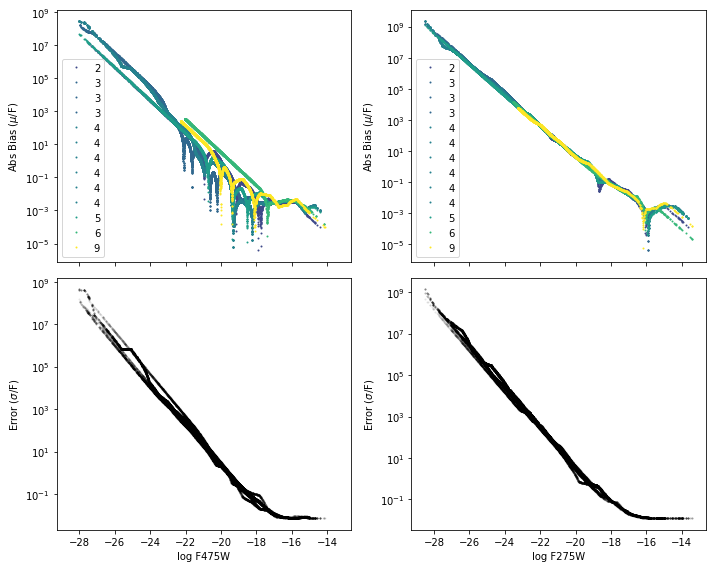

In [56]:
# set up the figure frame work
# have it scale with the number of filters we're plotting
fig, axes = plt.subplots(2, len(filter_list_plot), sharex=True, figsize=(5*len(filter_list_plot),8))

# go through noise files
for n, nfile in enumerate(noise_files):
    
    print("* reading " + nfile)

    # read in the values
    noisemodel_vals = noisemodel.get_noisemodelcat(nfile)

    # extract error and bias
    noise_err = noisemodel_vals.root.error[:]
    noise_bias = noisemodel_vals.root.bias[:]
    
    cmaps = plt.get_cmap('viridis')

    gradient = np.linspace(0, 1, len(noise_files))    

    # now we can start plotting things
    for f, filt in enumerate(filter_list_plot):
        
        # error is negative where it's been extrapolated -> trim those
        good_err = np.where(noise_err[:, f] > 0)[0]
        plot_sed = sed_grid[good_err, f][::samp] # only pulls every 100th point
        plot_err = noise_err[good_err, f][::samp]
        plot_bias = noise_bias[good_err, f][::samp]

        # plot bias
        axes[0, f].set_yscale('log')

        axes[0, f].plot(
            np.log10(plot_sed),
            np.abs(plot_bias) / plot_sed,
            marker="o",
            linestyle="none",
            mew=0,
            ms=2,
            alpha=1,
            c=cmaps(int(nfile[-10])/9.),
            label=noise_files[n][-10]
            )
        
        axes[0, f].set_ylabel(r"Abs Bias ($\mu$/F)", fontsize=10)
        # xlabel is still in flux, not mag
        axes[0, f].legend()

        # plot error (uncertainty)
        axes[1, f].set_yscale('log')

        axes[1, f].plot(
            np.log10(plot_sed),
            plot_err / plot_sed,
            marker="o",
            linestyle="none",
            mew=0,
            ms=2,
            color=color[0 % len(color)],
            alpha=0.1,)
        axes[1, f].set_ylabel(r"Error ($\sigma$/F)", fontsize=10)
        axes[1, f].set_xlabel("log " + filt[-5:], fontsize=10)

        plt.tight_layout()
        
    #fig.colorbar(plt.cm.ScalarMappable(norm=np.arange(0,12), cmap=cmaps), ax=axes)
    

    # Need to figure out if it's worth comparing the bias and the uncertainty to one another.

As you can probably tell, this plot isn't the most beautiful plot in the world (especially that coloring and legend) but I'm proud of her. It does, however, let you see the scale of the bias and uncertainty (error) for different filters and how the source density and magnitudes are correlated.

The most notable thing to note is that the uncertainty and bias tend to be larger at lower fluxes. This probably doesn't come as a shock to anyone, but it's important to accurately take this into consideration when we make our fittings in Step 9.

# Step 8. Trim Models


Now that we have our SED and or noise models created, we can go ahead and trim them of any sources that are so bright or so faint (compared to min/max flux in the observation file) that they will by definition produce effectively zero likelihood fits. 

One thing to note is that, since our noise models are correlated with source density, we are in a sense 'convolving' each of our noise models with the original physics grid, meaning we will end up with a lot of physics grids trimmed for each source density scenario thanks to our noise models (and these physics grids are still essentially as large as the original physics grid, making this a very storage-intensive step). However, this trimming of the 'parameter space', as you could call it, will help speed up fittings in Step 9.

**This step is very storage intensive so I'd make sure to have at least ~5GB of storage available.**


In [57]:
# check to see if any sub files exist yet
if len(glob.glob(file_dict["noise_trim_files"][0].replace('bin2_sub0','bin*_sub*'))) == 0:
    
    for i, sub_files in enumerate(file_dict["noise_trim_files"]):
        # pull out physics grid
        modelsedgrid = FileSEDGrid(model_grid_files[0])
        # trim for each noise file separately 
        noisemodel_vals = noisemodel.get_noisemodelcat(noise_files[i])
        obsdata = datamodel.get_obscat(gst_file_cut, modelsedgrid.filters)

        # need to iterate over all the sub-bins
        trim_grid.trim_models(modelsedgrid, noisemodel_vals, obsdata, file_dict["modelsedgrid_trim_files"][i], file_dict["noise_trim_files"][i])


Auto-detected type: hd5
Auto-detected type: fits
working on filter # =  0
working on filter # =  1
working on filter # =  2
working on filter # =  3
working on filter # =  4
working on filter # =  5
number of original models =  510048
number of ast trimmed models =  509563
number of trimmed models =  479060
Writing trimmed sedgrid to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin2_sub0_seds_trim.grid.hd5
Auto-detected type: hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin2_sub0_seds_trim.grid.hd5 (File) ''
Last modif.: 'Tue May  5 16:08:41 2020'
Object Tree: 
/ (RootGroup) ''
/grid (Table(479060,)) 'grid'
/lamb (EArray(6,)) 'lamb'
/seds (EArray(479060, 6)) 'seds'

Writing trimmed noisemodel to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin2_sub0_noisemodel_trim.grid.hd5
Auto-detected type: hd5
Auto-detected type: fits
working on filter # =  0
working on filter # =  1
working on filter # =  2
working on filter # =  3
working on filter # =  4
working on filter # =  5
number of ori

Auto-detected type: fits
working on filter # =  0
working on filter # =  1
working on filter # =  2
working on filter # =  3
working on filter # =  4
working on filter # =  5
number of original models =  510048
number of ast trimmed models =  510025
number of trimmed models =  479530
Writing trimmed sedgrid to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin5_sub0_seds_trim.grid.hd5
Auto-detected type: hd5
M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin5_sub0_seds_trim.grid.hd5 (File) ''
Last modif.: 'Tue May  5 16:12:48 2020'
Object Tree: 
/ (RootGroup) ''
/grid (Table(479530,)) 'grid'
/lamb (EArray(6,)) 'lamb'
/seds (EArray(479530, 6)) 'seds'

Writing trimmed noisemodel to disk into M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin5_sub0_noisemodel_trim.grid.hd5
Auto-detected type: hd5
Auto-detected type: fits
working on filter # =  0
working on filter # =  1
working on filter # =  2
working on filter # =  3
working on filter # =  4
working on filter # =  5
number of original models =  510048
n

#  Step 9. Fit Models (WARNING! This step takes a while)

Now we're going to fit all our sources from our observational photometric catalog to our new trimmed physics and noise models. This will take quite some time just because every source has to be evaluated at each step in its physics model. 

So for every sub-bin of sources (max 6250 sources), every source in that photometry file is evaluated at every potential step in the physics grid that has been trimmed to specifically fit that sub-bin (hence the data-intensive code we ran back in Step 8). From this, we essentially get a report of how well every point in the physics model (AKA combo of parameters) matched with a source, what is often referred to as a likelihood. If we then take these likelihoods and figure out what parameter values they point back to, we can create a distribution of parameter values (metallicity, distance, Av, Rv, etc.) that best model each source. I hope that made sense (and is the correct interpretation).

This function uses the trimmed photometric files we have, the trimmed physics models, and the trimmed noise models to create statistic files for each sub-binned source density bin.

It'll take a long time though (~5 hours for me at least, but maybe you have a better computer (8GB RAM, for reference)).

In [61]:
#if len(glob.glob(file_dict["modelsedgrid_trim_files"][0].replace('bin2_sub0','bin*_sub*'))) == 0:
run_fitting.run_fitting(
    use_sd = True,
    nsubs = 1,
    nprocs = 1,
    choose_sd_sub=None,
    choose_subgrid=None,
    pdf2d_param_list=['Av', 'Rv', 'f_A', 'M_ini', 'logA', 'Z', 'distance'],
    resume=False,
    )

Auto-detected type: fits
Auto-detected type: fits
Auto-detected type: fits
Auto-detected type: fits
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin2_sub0_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [34:16<00:00,  3.04it/s]  


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin3_sub0_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [27:55<00:00,  3.73it/s]  


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin3_sub1_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 985/985 [03:05<00:00,  5.32it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin3_sub2_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [26:55<00:00,  3.87it/s] 


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin4_sub0_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [27:01<00:00,  3.85it/s]  


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin4_sub1_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [23:10<00:00,  4.49it/s] 


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin4_sub2_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [21:23<00:00,  4.87it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin4_sub3_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 6250/6250 [20:40<00:00,  5.04it/s] 


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin4_sub4_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 2587/2587 [10:27<00:00,  4.12it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin4_sub5_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 2769/2769 [13:05<00:00,  3.52it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin5_sub0_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 324/324 [00:46<00:00,  6.92it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin6_sub0_seds_trim.grid.hd5
None
Auto-detected type: fits
Auto-detected type: hd5
not using full covariance matrix


Calculating Lnp/Stats: 100%|██████████| 8/8 [00:01<00:00,  6.56it/s]


Done fitting on grid M31-B09-EAST_chunk/M31-B09-EAST_chunk_bin9_sub0_seds_trim.grid.hd5
None
time to fit:  212.80141111666666  min


# Step 10. Merge fits

Whoo-hoo! You finished running the big Step 9!

We are now onto the final step where we just have to merge all the trimmed SED model results together. This should produce one final **stats.fits** file which is very similar to our original photometric file, except now all the sources have estimates for what their metallicity, distance, age, mass, dust, etc. might be.

Using these new columns of data, we can create lots of cool visuals which will be shown in the epilogue.

In [62]:
merge_files.merge_files(use_sd=True, nsubs=datamodel.n_subgrid)

Auto-detected type: fits
Auto-detected type: fits
Auto-detected type: fits
Auto-detected type: fits


Hopefully there is now a stats.fits file in your folder. We can read it in to better understand what really happened.

In [63]:
hdul = fits.open(sed_files[0].replace('seds.grid.hd5', 'stats.fits'))
Table(hdul[1].data)

Name,RA,DEC,HST_WFC3_F475W,HST_WFC3_F275W,HST_WFC3_F336W,HST_WFC3_F814W,HST_WFC3_F110W,HST_WFC3_F160W,Av_Best,Av_Exp,Av_p16,Av_p50,Av_p84,M_act_Best,M_act_Exp,M_act_p16,M_act_p50,M_act_p84,M_ini_Best,M_ini_Exp,M_ini_p16,M_ini_p50,M_ini_p84,Rv_Best,Rv_Exp,Rv_p16,Rv_p50,Rv_p84,Rv_A_Best,Rv_A_Exp,Rv_A_p16,Rv_A_p50,Rv_A_p84,Z_Best,Z_Exp,Z_p16,Z_p50,Z_p84,distance_Best,distance_Exp,distance_p16,distance_p50,distance_p84,f_A_Best,f_A_Exp,f_A_p16,f_A_p50,f_A_p84,logA_Best,logA_Exp,logA_p16,logA_p50,logA_p84,logHST_WFC3_F110W_nd_Best,logHST_WFC3_F110W_nd_Exp,logHST_WFC3_F110W_nd_p16,logHST_WFC3_F110W_nd_p50,logHST_WFC3_F110W_nd_p84,logHST_WFC3_F110W_wd_Best,logHST_WFC3_F110W_wd_Exp,logHST_WFC3_F110W_wd_p16,logHST_WFC3_F110W_wd_p50,logHST_WFC3_F110W_wd_p84,logHST_WFC3_F160W_nd_Best,logHST_WFC3_F160W_nd_Exp,logHST_WFC3_F160W_nd_p16,logHST_WFC3_F160W_nd_p50,logHST_WFC3_F160W_nd_p84,logHST_WFC3_F160W_wd_Best,logHST_WFC3_F160W_wd_Exp,logHST_WFC3_F160W_wd_p16,logHST_WFC3_F160W_wd_p50,logHST_WFC3_F160W_wd_p84,logHST_WFC3_F275W_nd_Best,logHST_WFC3_F275W_nd_Exp,logHST_WFC3_F275W_nd_p16,logHST_WFC3_F275W_nd_p50,logHST_WFC3_F275W_nd_p84,logHST_WFC3_F275W_wd_Best,logHST_WFC3_F275W_wd_Exp,logHST_WFC3_F275W_wd_p16,logHST_WFC3_F275W_wd_p50,logHST_WFC3_F275W_wd_p84,logHST_WFC3_F336W_nd_Best,logHST_WFC3_F336W_nd_Exp,logHST_WFC3_F336W_nd_p16,logHST_WFC3_F336W_nd_p50,logHST_WFC3_F336W_nd_p84,logHST_WFC3_F336W_wd_Best,logHST_WFC3_F336W_wd_Exp,logHST_WFC3_F336W_wd_p16,logHST_WFC3_F336W_wd_p50,logHST_WFC3_F336W_wd_p84,logHST_WFC3_F475W_nd_Best,logHST_WFC3_F475W_nd_Exp,logHST_WFC3_F475W_nd_p16,logHST_WFC3_F475W_nd_p50,logHST_WFC3_F475W_nd_p84,logHST_WFC3_F475W_wd_Best,logHST_WFC3_F475W_wd_Exp,logHST_WFC3_F475W_wd_p16,logHST_WFC3_F475W_wd_p50,logHST_WFC3_F475W_wd_p84,logHST_WFC3_F814W_nd_Best,logHST_WFC3_F814W_nd_Exp,logHST_WFC3_F814W_nd_p16,logHST_WFC3_F814W_nd_p50,logHST_WFC3_F814W_nd_p84,logHST_WFC3_F814W_wd_Best,logHST_WFC3_F814W_wd_Exp,logHST_WFC3_F814W_wd_p16,logHST_WFC3_F814W_wd_p50,logHST_WFC3_F814W_wd_p84,logL_Best,logL_Exp,logL_p16,logL_p50,logL_p84,logT_Best,logT_Exp,logT_p16,logT_p50,logT_p84,logg_Best,logg_Exp,logg_p16,logg_p50,logg_p84,mbolmag_Best,mbolmag_Exp,mbolmag_p16,mbolmag_p50,mbolmag_p84,radius_Best,radius_Exp,radius_p16,radius_p50,radius_p84,symlogHST_WFC3_F475W_wd_bias_Best,symlogHST_WFC3_F475W_wd_bias_Exp,symlogHST_WFC3_F475W_wd_bias_p16,symlogHST_WFC3_F475W_wd_bias_p50,symlogHST_WFC3_F475W_wd_bias_p84,symlogHST_WFC3_F275W_wd_bias_Best,symlogHST_WFC3_F275W_wd_bias_Exp,symlogHST_WFC3_F275W_wd_bias_p16,symlogHST_WFC3_F275W_wd_bias_p50,symlogHST_WFC3_F275W_wd_bias_p84,symlogHST_WFC3_F336W_wd_bias_Best,symlogHST_WFC3_F336W_wd_bias_Exp,symlogHST_WFC3_F336W_wd_bias_p16,symlogHST_WFC3_F336W_wd_bias_p50,symlogHST_WFC3_F336W_wd_bias_p84,symlogHST_WFC3_F814W_wd_bias_Best,symlogHST_WFC3_F814W_wd_bias_Exp,symlogHST_WFC3_F814W_wd_bias_p16,symlogHST_WFC3_F814W_wd_bias_p50,symlogHST_WFC3_F814W_wd_bias_p84,symlogHST_WFC3_F110W_wd_bias_Best,symlogHST_WFC3_F110W_wd_bias_Exp,symlogHST_WFC3_F110W_wd_bias_p16,symlogHST_WFC3_F110W_wd_bias_p50,symlogHST_WFC3_F110W_wd_bias_p84,symlogHST_WFC3_F160W_wd_bias_Best,symlogHST_WFC3_F160W_wd_bias_Exp,symlogHST_WFC3_F160W_wd_bias_p16,symlogHST_WFC3_F160W_wd_bias_p50,symlogHST_WFC3_F160W_wd_bias_p84,chi2min,chi2min_indx,Pmax,Pmax_indx,specgrid_indx,total_log_norm,reorder_tag
str29,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,

As you can hopefully see, for every source, there are now several parameters assigned to each one. These are all the parameters we originally had set up in our datamodel and specified in Step 9.

# Epilogue: Visualizating!

In [64]:
from beast.plotting import (
    plot_triangle, 
    plot_indiv_fit, 
    plot_cmd_with_fits, 
    plot_completeness, 
    plot_chi2_hist,
)

### Triangle Plot

This first plot displays a posterior distributions of the parameters of all the fitted stars. 

In [73]:
plot_triangle.plot_triangle("M31-B09-EAST_chunk/M31-B09-EAST_chunk_stats.fits")

### CMD Plot

You can also make a color-magnitude diagram of the observations and color-code the data points using one of the parameters from the BEAST fitting (feel free to change this from the example, just remember that the param must match a column name from the stat.fits file). 

Inputs are the photometry file, three filters, the BEAST stats file from Step 10, and the parameter to use and apply color to after taking the log10.

/home/christina/anaconda3/envs/astroconda/lib/python3.6/site-packages/beast/plotting/plot_cmd_with_fits.py:97: RuntimeWarning: invalid value encountered in greater
  col[col > 99] = np.nan


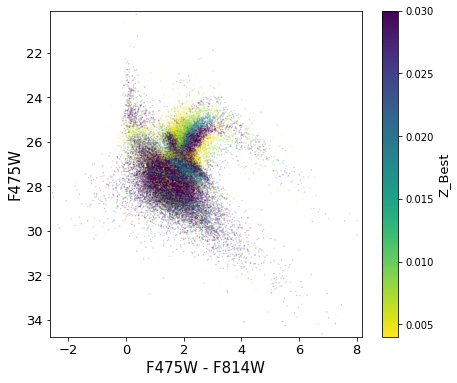

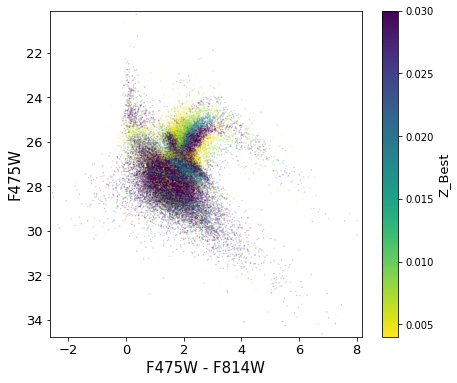

In [67]:
plot_cmd_with_fits.plot(data_fits_file="M31-B09-EAST_chunk.st_with_sourceden_cut.fits", 
                        beast_fits_file="M31-B09-EAST_chunk/M31-B09-EAST_chunk_stats.fits", 
                        mag1_filter="F475W",
                        mag2_filter="F814W",
                        mag3_filter="F475W",
                        param="Z_Best", #metallicity
                       )

### Completeness Plot
This next plot shows the completeness (how many AST sources were detected out of the total number of AST that exist for that parameter bin) for each parameter, although it should be noted that the *distance* parameter was purposefully left out because all the sources have the same distance value, and thus the plotting code isn't sure how to handle it.

In [70]:
plot_completeness.plot_completeness(physgrid_list=file_dict["modelsedgrid_trim_files"],
                                    noise_model_list=file_dict["noise_trim_files"],
                                    output_plot_filename="completeness_plot.pdf",
                                    param_list=['Av', 'Rv', 'logA', 'f_A', 'M_ini', 'Z'],
                                    #, 'distance'],
                                    compl_filter='F475W',)

Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
Auto-detected type: hd5
Completeness from HST_WFC3_F475W
plotting Av and Av
plotting Av and Rv
plotting Av and logA
plotting Av and f_A
plotting Av and M_ini
plotting Av and Z
plotting Rv and Rv
plotting Rv and logA
plotting Rv and f_A
plotting Rv and M_ini
plotting Rv and Z
plotting logA and logA
plotting logA and

/home/christina/anaconda3/envs/astroconda/lib/python3.6/site-packages/beast/plotting/plot_completeness.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig)


### Chi Squared Plot
Make a histogram of the best chi2 values (chi2=1 and the median chi2 are marked). Note that there is no plot of reduced chi2, because it is mathematically difficult to define the number of degrees of freedom. Inputs are the BEAST stats file and optionally the number of bins to use for the histogram.

In [71]:
plot_chi2_hist.plot(beast_stats_file="M31-B09-EAST_chunk/M31-B09-EAST_chunk_stats.fits")


There's another cool plot for plotting the individual fits of stars, but unfortunately, this code works with a file that only gets generated when using multiple subgrids (remember how we checked that we had a subgrid = 1 back in Step 2?). If it had worked with the code below, it would have made a multi-panel plot that shows the PDFs and best fits of each parameter for any given star, as well as the SED (similar to Figure 14 in Gordon+16).

In [39]:
#plot_indiv_fit.plot_beast_ifit(filter=datamodel.filters, waves, stats, pdf1d_hdu, starnum=0):

Sorry I wasn't able to show you all that last plot. But thanks for reading through this notebook til the end. Hopefully you found it to be somewhat helpful and if you have any suggestions for how to make it better, you can find me at cwlind@jhu.edu.

Thanks,\
Christina Lindberg\
(she/her)